[View in Colaboratory](https://colab.research.google.com/github/LjBLincoln/Machine_Learning/blob/master/wxplusb.ipynb)

# Demo (y = wx+b)

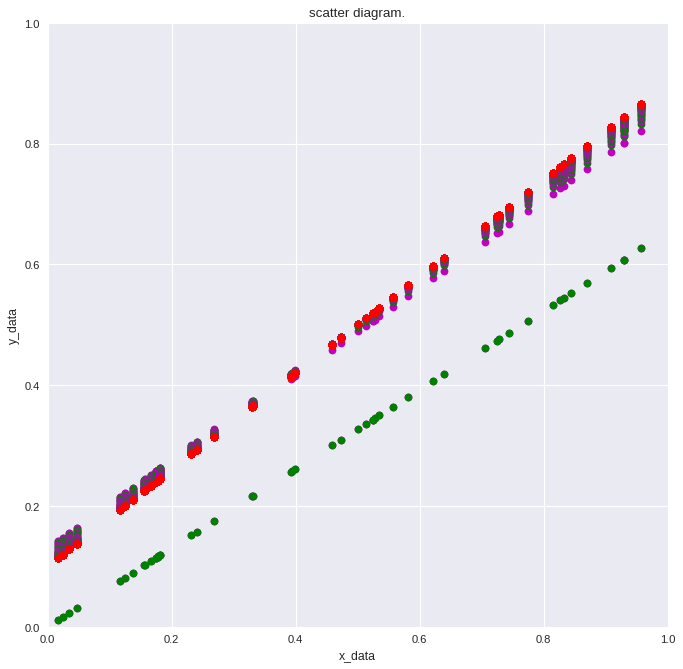

Done !!!


In [95]:
# _*_ coding: utf-8 _*_

import matplotlib.pyplot as plt

import tensorflow as tf

import numpy as np

MAX_STEPS = 500

# create data 生成100个0-1之间的随机数   np.random.rand(100) 1*100的矩阵
#np.random.rand(3,3) 3*3的矩阵，其每个元素为0-1的随机数
x_data = np.random.rand(50).astype(np.float32)
y_data = x_data * 0.8 + 0.1

#input module
with tf.name_scope('input'):
    with tf.name_scope('x'):
        x = tf.placeholder(tf.float32, shape = (50), name = "x")

# layer
with tf.name_scope('slayer'):
    with tf.name_scope('weights'):
        ### create tensorflow structure start ###对权进行赋值 在-1到一之间随机数
        #uniform([1]为1*1的矩阵，即一个数
        Weights = tf.Variable(tf.random_uniform([1], -1.0, 1.0))
        tf.summary.histogram('Weights' ,Weights)
    with tf.name_scope('biases'):
        #偏差为零，zeros([1]为一个1*1的零矩阵，即初始偏差为零
        biases = tf.Variable(tf.zeros([1]))
        tf.summary.histogram('biases' ,biases)
    with tf.name_scope('Wx_plus_b'):
        #权值与x相乘并加偏差
        y = Weights * x + biases 

#Mean Squared Error)
with tf.name_scope('Mean_Squared_Error'):
    #方差，(y-y_data)平方，求和，取均值
    loss = tf.reduce_mean(tf.square(y-y_data))
    tf.summary.scalar('loss', loss)

#Optimizer
with tf.name_scope('train'):
    #定义梯度下降法优化函数，优化，步长为0.5
    optimizer = tf.train.GradientDescentOptimizer(0.1)
    #tf.summary.scalar('optimizer', optimizer)
    train = optimizer.minimize(loss)
    

merged = tf.summary.merge_all()

init = tf.global_variables_initializer()
#session
sess = tf.Session()

#create FileWriter and loadd graph
train_writer = tf.summary.FileWriter('./log', sess.graph)

sess.run(init)

plt.figure(figsize=(10, 10), dpi=80)
plt.ion()

for step in range(MAX_STEPS):
    
    plt.title("scatter diagram.")
    plt.xlabel("x_data")
    plt.ylabel("y_data")
    plt.xlim(xmax=1, xmin=0)
    plt.ylim(ymax=1,ymin=0)
    plt.plot(x_data,y_data,'ro',color='r',linewidth=0.5)

    y_re,t,w,b = sess.run([y,train,Weights,biases],feed_dict = {x: x_data})
    

    if step % 10 == 0:
        plt.plot(x_data,y_re,'ro', color='m',linewidth=0.5)
    if step % 15 == 0:
        plt.plot(x_data,y_re,'ro', color='g',linewidth=0.5)

    

plt.ioff()
plt.show()
    
#close FileWriter
train_writer.close()
sess.close()

print("Done !!!")

# TensorBoard

In [96]:
#https://www.dlology.com/blog/quick-guide-to-run-tensorboard-in-google-colab/

!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

LOG_DIR = './log'
get_ipython().system_raw('tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'.format(LOG_DIR))

get_ipython().system_raw('./ngrok http 6006 &')


! curl -s http://localhost:4040/api/tunnels | python3 -c "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"



--2018-10-19 06:34:49--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 34.235.97.255, 35.173.3.255, 52.1.117.85, ...
Connecting to bin.equinox.io (bin.equinox.io)|34.235.97.255|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5363700 (5.1M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip.5’

ngrok-stable-linux- 100%[===================>]   5.11M  --.-KB/s    in 0.1s    

2018-10-19 06:34:49 (47.3 MB/s) - ‘ngrok-stable-linux-amd64.zip.5’ saved [5363700/5363700]

Archive:  ngrok-stable-linux-amd64.zip
replace ngrok? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: ngrok                   
https://69effd40.ngrok.io
